In [1]:

# Reloading
%reload_ext autoreload
%autoreload 2

import pandas as pd
print('pandas version:{}'.format(pd.__version__))
import numpy as np
print('numpy version:{}'.format(np.__version__))
import math
from datetime import datetime
from dgpylib import dg_athena
from dgpylib import dg_s3
import os
import re
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import timedelta
from dateutil.relativedelta import relativedelta

import sys
sys.path.insert(0, '../Modelling')
import helper_function2 as hf

import sys
sys.path.insert(0, '../EDA')
import data_integrity_fixer as dint
import basicstatsandplotter as bsp
import data_imputer as di
import data_integrity_fixer as dif
import parameters

##for modelling
import h2o
print('h2o version:{}'.format(h2o.__version__))
from h2o.estimators import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OTargetEncoderEstimator
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.tree import H2OTree
from h2o.tree import H2ONode
from h2o.tree import H2OSplitNode
from h2o.tree import H2OLeafNode
from h2o.estimators.kmeans import H2OKMeansEstimator

#import xgboost as xgb
import sklearn
import category_encoders as ce
print('sklearn version:{}'.format(sklearn.__version__))
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.preprocessing import PowerTransformer
import time
import parameters
from statsmodels.stats.outliers_influence import variance_inflation_factor

%run 'functions.ipynb'

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100

pandas version:1.3.4
numpy version:1.20.3
h2o version:3.36.0.4
sklearn version:1.1.2


# Pre-Processing 
<a id="section1"></a>

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [24]:
conn_s3 = dg_s3.Connect('dgdatadump/DS&CA/Pricing/02 Projects/2022/Tel_Reg_2.0/Cancellation Model')
df_raw = conn_s3.read('TelReg_Cancellation_Planmaster.csv')
print(df_raw.shape)
print(df_raw['movementdate'].min(), df_raw['movementdate'].max())
print(df_raw['planaccdate'].min(), df_raw['planaccdate'].max())

(751582, 92)
1210102 1220818
1210101 1220817


In [27]:
df_raw.columns.to_list()

['offerreferencenumber',
 'offereffectivedatetime',
 'offereffectiveweek',
 'offeracceptedprice',
 'offerbusinesseventcode',
 'offerpostcode',
 'offeracceptedindicator',
 'sale',
 'offertotalprice',
 'persongoldencopyid',
 'itemgoldencopyid',
 'itemeventuserid',
 'contractcreateddate',
 'contractstatuscode',
 'contractcompanycode',
 'contractschemecode',
 'contractnumber',
 'contractstatusname',
 'contractenddate',
 'contractmovementdate',
 'contractoriginalstartdate',
 'contractdimensionid',
 'contracteventdatetime',
 'itemcategoryname',
 'itemsupercategorycode',
 'itemgoodscategoryname',
 'manufacturerbrandname',
 'manufacturergroupname',
 'itemmodelnumber',
 'itempurchaseprice',
 'itempurchasedatetime',
 'itemlocationpostcode',
 'personaddresspostcode',
 'planno',
 'gross',
 'planaccdate',
 'rec_status',
 'planstatus',
 'cocode',
 'schcode',
 'movementdate',
 'PmhId',
 'TotalPrice',
 'PeriodOfCover',
 'PricingVersionDescription',
 'PredictedConversionRate',
 'ModelId',
 'PerhId',
 '

In [31]:
df_raw[df_raw.contractstatuscode=='C'][['schcode', 'cocode', 'planno', 'planaccdate', 'movementdate', 'gross', 'offertotalprice']].head()

,schcode,cocode,planno,planaccdate,movementdate,gross,offertotalprice
4,BNG,D,108951,1210605,1210809,49.72,54.24
8,BAN,D,6606,1220119,1220308,49.39,53.88
10,BNJ,D,263715,1220110,1220117,65.04,65.04
19,BNG,D,120591,1210907,1211101,47.16,47.16
22,AT1,D,73340,1220520,1220607,61.20,61.20


## Preliminary Filters
<a id='prefilt'></a>

In [4]:
# keep only POC == 12 months
df_raw =  df_raw[df_raw['PeriodOfCover']==12]

# filter out Sky, Heating
df_raw = df_raw[(df_raw['manufacturerbrandname']!='SKY')&(df_raw['itemgoodscategoryname']!='HEATING')]
df_raw.shape

df_raw = df_raw.loc[df_raw.PricingVersionDescription != 'TEST']

## Dedup
<a id='dedup'></a>

In [5]:
# check duplicate offers
df_raw[df_raw.duplicated(subset='offerreferencenumber')].shape

# dedup offers
df_dedup = df_raw.drop_duplicates(subset='offerreferencenumber', keep='first')
df_dedup.shape, df_raw.shape

((721573, 92), (726675, 92))

## Rename & Drop Columns
<a id='rename'></a>

In [6]:
rename_list = parameters.rename_list
drop_list = parameters.drop_list

In [7]:
df = df_dedup.copy()
df.rename(columns=rename_list, inplace=True)
df = hf.drop_columns(df, drop_list)

df.shape, df_raw.shape

((721573, 45), (726675, 92))

## Data Formatting
<a id='form'></a>

In [8]:
# dates

date_cols = df.columns[df.columns.str.lower().str.contains('date')]

# convert planmaster to datetime string
df = planmaster_date_to_datetime(df, columns=['planaccdate', 'movementdate']) 
date_fix(df, date_cols) # convert to datetime

print(df['CurrentDate'].min(), df['CurrentDate'].max())
print(df['movementdate'].min(), df['movementdate'].max())
print(df['planaccdate'].min(), df['planaccdate'].max())

2021-01-01 00:00:00 2022-08-01 00:00:00
2021-01-02 00:00:00 2022-08-18 00:00:00
2021-01-01 00:00:00 2022-08-17 00:00:00


In [9]:
# # Convert to Int
# for col in ['ClaimPast1YearCount', 'ClaimPast3YearCount', 'ClaimPast5YearCount', 'PlanLiveCount', 'PlansAcceptedPast1YearCount', 'PlansAcceptedPast5YearCount', 'PlansActivePast1yrCount', 'PlansActivePast5yrCount', 'PlansCancelledPast1YearCount', 'PlansCancelledPast5YearCount']:
#     df[col]= df[col].astype('Int64')
    
# Convert to Datetime
# df['CurrentDate'] = pd.to_datetime(df['CurrentDate']) 
# df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])

# Convert to String
for i in ['ClientGroupCode', 'ClientCode']:
    df[i] = np.where(df[i].isna(), df[i], df[i].astype('string'))
    print(i, ':', df[i].isna().sum(), df[i].dtypes)
    # print(dif.get_othernulls_count(df[i]))
# df.astype({"PmhId":str,"PerhId":str ,"ClientGroupCode": str,  "ClientCode": str})

# Create new features
df['HasPrevRTPPrice'] = np.where(df['PrevRTPPriceType'].isna(), 'N', 'Y')
df['AppAge'] = (df['CurrentDate'] - df['PurchaseDate']) / np.timedelta64(1, 'D')
# df['AppAge'] = np.where(pd.to_datetime(df['CurrentDate'])>=pd.to_datetime(df['PurchaseDate']),(pd.to_datetime(df['CurrentDate']) - pd.to_datetime(df['PurchaseDate'])) / np.timedelta64(1, 'D'), np.nan)
# df['AppAge'] = df['AppAge'].fillna(df['item_age'].mean())
df['relFee'] = df['Fee']/ df['PurchasePrice']
df['relFeeInc'] = df['price_diff']/ df['PurchasePrice']
df['PaymentType']= 'DD'

# Impute Counts in Pricing Table
to_impute = ['PlanLiveCount', 'PlansActivePast1yrCount',
       'PlansActivePast5yrCount', 'PlansAcceptedPast1YearCount',
       'PlansAcceptedPast5YearCount', 'PlansCancelledPast1YearCount',
       'PlansCancelledPast5YearCount', 'ClaimPast1YearCount',
       'ClaimPast3YearCount', 'ClaimPast5YearCount',
       'ClaimAmount1YearTotal', 'ClaimAmount3YearTotal', 'ClaimAmount5YearTotal']

df[to_impute] = df[to_impute].fillna(0)


ClientGroupCode : 198153 object
ClientCode : 198153 object


In [10]:
# convert count columns to integer
count_cols = list(df.columns[df.columns.str.lower().str.contains('count')])
count_cols

['PlanLiveCount',
 'PlansActivePast1yrCount',
 'PlansActivePast5yrCount',
 'PlansAcceptedPast1YearCount',
 'PlansAcceptedPast5YearCount',
 'PlansCancelledPast1YearCount',
 'PlansCancelledPast5YearCount',
 'ClaimPast1YearCount',
 'ClaimPast3YearCount',
 'ClaimPast5YearCount',
 'ClientAccountDesc']

In [11]:
count_cols.remove('ClientAccountDesc')
df[count_cols] = df[count_cols].astype(int)
df[count_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 721573 entries, 1 to 751581
Data columns (total 10 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   PlanLiveCount                 721573 non-null  int64
 1   PlansActivePast1yrCount       721573 non-null  int64
 2   PlansActivePast5yrCount       721573 non-null  int64
 3   PlansAcceptedPast1YearCount   721573 non-null  int64
 4   PlansAcceptedPast5YearCount   721573 non-null  int64
 5   PlansCancelledPast1YearCount  721573 non-null  int64
 6   PlansCancelledPast5YearCount  721573 non-null  int64
 7   ClaimPast1YearCount           721573 non-null  int64
 8   ClaimPast3YearCount           721573 non-null  int64
 9   ClaimPast5YearCount           721573 non-null  int64
dtypes: int64(10)
memory usage: 60.6 MB


In [12]:
df = hf.drop_columns(df, drop_list)

## Basic Statistics
<a id='stats'></a>

In [13]:
#dtypes
x= df.dtypes.to_frame().reset_index()
x.columns = ['ColName', 'dtype']
x= x.sort_values(by= 'ColName')

#missing
y= df.isna().sum().to_frame().reset_index()
y.columns = ['ColName', 'Na_rows']
y= y.sort_values(by= 'ColName')

#describe
d= df.describe(percentiles= [.1, .9, .95, .975]).T.reset_index()
d.columns = ['ColName', 'count', 'mean', 'std', 'min', '10%', '50%', '90%', '95%', '97.5%', 'max']
d= d.sort_values(by= 'ColName')

#join
z= x.merge(y, on= 'ColName', how= 'left').merge(d, on='ColName', how= 'left')
z['N'] = df.shape[0]
z['Na_miss_rate'] = (z['Na_rows'] / z['N']) * 100

z['dtype'] = z['dtype'].astype('str')

fltr= z['dtype'].isin(['float64'])
z.style.format('{:,.2f}', subset=['mean', 'std', 'min', '10%', '50%', '90%', '95%', '97.5%', 'max', 'Na_miss_rate']).format('{:,.0f}', subset=['N', 'Na_rows', 'count'])

,ColName,dtype,Na_rows,count,mean,std,min,10%,50%,90%,95%,97.5%,max,N,Na_miss_rate
0,AppAge,float64,"198,153","523,420",107.61,189.65,0.00,0.00,14.00,365.00,549.05,731.00,"1,217.00","721,573",27.46
1,ApplianceCode,object,"198,153",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"721,573",27.46
2,ClaimAmount1YearTotal,float64,0,"721,573",38.67,168.53,0.00,0.00,0.00,85.03,223.57,428.08,"9,198.77","721,573",0.00
3,ClaimAmount3YearTotal,float64,0,"721,573",93.11,351.13,-254.84,0.00,0.00,253.42,561.78,953.48,"17,209.60","721,573",0.00
4,ClaimAmount5YearTotal,float64,0,"721,573",132.97,474.49,"-7,127.94",0.00,0.00,373.83,805.03,"1,318.17","22,468.61","721,573",0.00
5,ClaimPast1YearCount,int64,0,"721,573",0.30,1.07,0.00,0.00,0.00,1.00,2.00,3.00,54.00,"721,573",0.00
6,ClaimPast3YearCount,int64,0,"721,573",0.75,2.43,0.00,0.00,0.00,2.00,5.00,7.00,124.00,"721,573",0.00
7,ClaimPast5YearCount,int64,0,"721,573",1.11,3.50,0.00,0.00,0.00,4.00,7.00,11.00,181.00,"721,573",0.00
8,ClientAccountDesc,object,"198,153",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"721,573",27.46
9,ClientCode,object,"198,153",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"721,573",27.46


## Single Value & Null Columns
<a id='singlenull'></a>

In [14]:
# split columns by type
categorical_cols, integer_cols, float_cols, date_cols, unidentified_cols = hf.cat_num_split(df)

# count unique values
feature_uniques_count, low_cardinality_features_unique_values= bsp.unique_count(df[categorical_cols])

# Single value categorical columns
single_val = list([key for key, value in feature_uniques_count.items() if value == 1 ])
single_val.remove('PaymentType')

#drop single value categorical cols
df = hf.drop_columns(df, single_val)

# drop single value numerical columns
df = hf.drop_columns(df,['rec_status', 'PredictedConversionRate'])

# null columns
na_count = df.apply(dint.get_nulls_count)
null_cols = na_count[na_count.values>=80].index
null_cols

# drop cols with >80% nulls
df = hf.drop_columns(df, null_cols)

## Categorical Features
<a id='catfeat'></a>

In [15]:
# reduce cardinality of certain categorical features

cat_features = [f for f in df.select_dtypes(include=['object']).columns.sort_values() if f not in ['CurrentDate', 'PurchaseDate', 'ons_postcode_sector', 'PerPostalAddrPostCode', 'RouteToMarketName', 'PrevRTPPriceType', 'SchemeTypeName', 'planaccdate', 'movementdate']]
id_cols = ['offerreferencenumber', 'itemeventuserid', 'ModelId']
postcode_cols = ['personaddresspostcode', 'offerpostcode', 'Postcode_Sector']

In [16]:
to_group = list(set(cat_features) - set(id_cols) - set(postcode_cols))
for i in to_group:
    print(f'{i}:{df[i].nunique()}')

PaymentType:1
ApplianceCode:111
ClientGroupCode:54
price_band:7
ClientAccountDesc:38
HasPrevRTPPrice:2
ManufacturerBrandCode:114
ClientGroupDesc:20
GoodsColour:2
ClientCode:84
contractstatuscode:4
PricingVersionDescription:17


In [17]:
group_low_freq(df=df, lst= to_group, pct=2.5) # regroup very low frequency classes
for i in to_group:
    print(f'{i}:{df[i].nunique()}')

PaymentType:1
ApplianceCode:12
ClientGroupCode:7
price_band:7
ClientAccountDesc:12
HasPrevRTPPrice:2
ManufacturerBrandCode:12
ClientGroupDesc:9
GoodsColour:2
ClientCode:9
contractstatuscode:3
PricingVersionDescription:5


In [18]:
df_dedup[df_dedup['requested_clientaccountdesc']=='HSBC'].shape[0]/df_dedup.shape[0]

0.00011225475454319936

In [19]:
df[df['ClientAccountDesc']=='HSBC'].shape[0]

0

In [20]:
categorical_cols, integer_cols, float_cols, date_cols, unidentified_cols = hf.cat_num_split(df)
categorical_cols

['offerreferencenumber',
 'CurrentDate',
 'offerpostcode',
 'contractstatuscode',
 'personaddresspostcode',
 'planaccdate',
 'movementdate',
 'PricingVersionDescription',
 'PurchaseDate',
 'GoodsColour',
 'ClientGroupDesc',
 'SchemeTypeName',
 'ClientAccountDesc',
 'RouteToMarketName',
 'ApplianceCode',
 'ClientGroupCode',
 'ClientCode',
 'ManufacturerBrandCode',
 'Postcode_Sector',
 'price_band',
 'HasPrevRTPPrice',
 'PaymentType']

In [22]:
#strip whitespace in categorical columns
for i in list(set(categorical_cols) - set(date_cols)):
    if (df[i].isna().any()):
        break
    print(i)
    df[i] = df[i].apply(lambda x: str(x).replace(" ", "").upper())

# find na's
cat_nulls = df[categorical_cols].apply(dint.get_nulls_count)
cat_to_impute = list(cat_nulls[cat_nulls.values>0].index)

# impute na's
df[cat_to_impute]=df[cat_to_impute].apply(lambda x: x.fillna(x.mode().iloc[0]))

In [25]:
df['Postcode_Sector'] = df['Postcode_Sector'].apply(lambda x: str(x).replace(" ", "").upper())
df['Postcode_Sector'].head()

1    IP257
3     M156
4    NP167
5     W114
6     RG49
Name: Postcode_Sector, dtype: object

## Numerical Features
<a id='numfeat'></a>

In [28]:
num_features = [f for f in df.select_dtypes(include=['int32', 'int64', 'float64']).columns.sort_values() if f not in ['planno']]

# capping by quantile

# for col in num_features:
#     df[col]= df[col].clip(upper= np.quantile(df[col], q= 0.95))
#     df[col]= df[col].clip(lower= np.quantile(df[col], q= 0.05))

# float cols
float_nulls = df[float_cols].apply(dint.get_nulls_count)
float_null_cols = list(float_nulls[float_nulls.values>0].index)
# replace missing offertotalprice with Fee
df['offertotalprice'] = df['offertotalprice'].fillna(df['Fee'])
float_null_cols.remove('offertotalprice')

# integer cols
integer_nulls = df[integer_cols].apply(dint.get_nulls_count)
integer_null_cols = integer_nulls[integer_nulls.values>0].index

num_to_impute = list(float_null_cols)+list(integer_null_cols)

# num imputation 
df[num_to_impute]= di.impute_mean(df, num_to_impute, 'ClientGroupCode')

In [29]:
# date cols
df[date_cols].apply(dint.get_nulls_count)

CurrentDate     0.0
planaccdate     0.0
movementdate    0.0
PurchaseDate    0.0
dtype: float64

## Date Features
<a id='datefeat'></a>

### Feature Engineering

In [30]:
df['planaccdate'].head()

1    2022-05-11
3    2021-07-16
4    2021-06-05
5    2022-07-14
6    2021-07-05
Name: planaccdate, dtype: object

In [31]:
# Convert to Datetime
df['planaccdate'] = pd.to_datetime(df['planaccdate']) 
df['movementdate'] = pd.to_datetime(df['movementdate'])

# df[date_cols].apply(lambda x: x.dt.date)

In [32]:
# month-year column
# df_dedup['offermonthyear'] = df_dedup['CurrentDate'].dt.to_period('M')
df['startmonthyear'] = df['planaccdate'].dt.to_period('M')
df['contractmonthyear'] = df['movementdate'].dt.to_period('M')

# month name column
# df_dedup['offereventmonth'] = df_dedup['CurrentDate'].dt.month_name()
df['startmonth'] = df['planaccdate'].dt.month_name()
df['contractmonth'] = df['movementdate'].dt.month_name()

In [33]:
# calculate contract tenure
# if cancelled, contract_age is measured up to movementdate, otherwise it's up to latest date in the dataset
final_date = df['movementdate'].max()
df['contract_age']=np.where(df['contractstatuscode']=='C', (df['movementdate']-df['planaccdate'])/np.timedelta64(1, 'M'), (final_date-df['planaccdate'])/np.timedelta64(1, 'M'))
df[df['contract_age']<0].shape
# df_dedup.drop('contract_age', axis=1, inplace=True)

(0, 52)

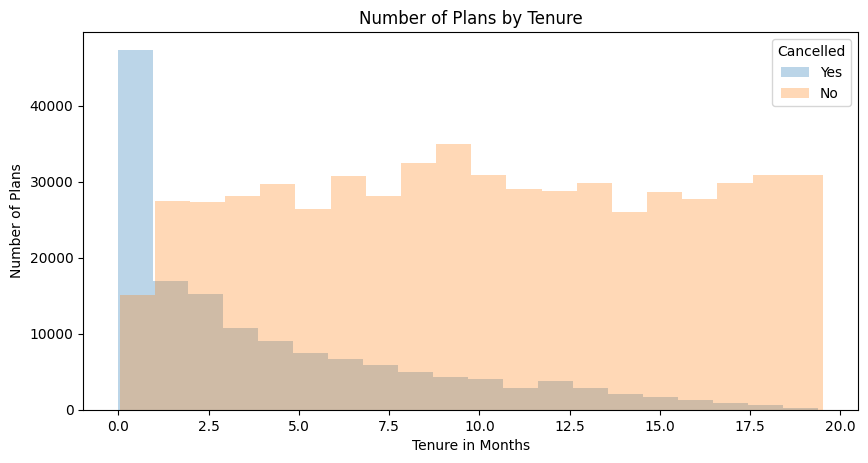

In [34]:
x1 = df[df['contractstatuscode']=='C']['contract_age']
x2 = df[df['contractstatuscode']!='C']['contract_age']
kwargs = dict(histtype='stepfilled', alpha=0.3, bins=20)
plt.hist(x1.values, **kwargs, label = "Yes")
plt.hist(x2.values, **kwargs, label = "No")
plt.xlabel("Tenure in Months")
plt.ylabel("Number of Plans")
plt.title("Number of Plans by Tenure")
plt.legend(title='Cancelled')
plt.show()

## Target Variable: Cancellation Flag
<a id='target'></a>

In [35]:
# create target variable for the model
df['cancelflag']=np.where(df['contractstatuscode']=='C', 1, 0)
df['cancelflag'].sum(), df.shape

(149116, (721573, 53))

In [36]:
df_raw1 = df.copy()

# Merge with Geovariable
<a id='section3'></a>

In [37]:
telreg = df_raw1.copy()

In [38]:
conn1 = dg_s3.Connect('dgdatadump/DS&CA/Reference Files/ONS/Processed')
geo_df = conn1.read('Earnix_Geo_Look_Up_by_PC.csv')

In [39]:
all_features = geo_df.columns

ons_feats = all_features[all_features.str.contains('ONS_')]
ons_feats = ons_feats.to_list()

hpi_feats =['HPI_AveragePrice', 'HPI_SalesVolume']

geo_feats = hpi_feats + ons_feats
geo_feats.remove('ONS_postcode_sector')
geo_feats.remove('ONS_Unnamed: 0')

## Merge
<a id="merge"></a>

In [40]:
# merge 
telreg_merged = telreg.merge(geo_df, how='left', left_on='offerpostcode', right_on='pcds')

# dedup
telreg_dedup = telreg_merged.drop_duplicates(subset=['offerreferencenumber'], keep='first')

telreg_dedup.drop('ONS_Unnamed: 0', inplace=True, axis=1)

## Impute
<a id='imp'></a>

In [41]:
# 1st, impute by LAD_name
for i in geo_feats:
    telreg_geo_imputed = hf.num_imputation(telreg_dedup, i, 'LAD_name')
# 2nd, impute by region 
for i in geo_feats:
    telreg_geo_imputed = hf.num_imputation(telreg_geo_imputed, i, 'region')
# 3rd, impute by country
for i in geo_feats:
    telreg_geo_imputed = hf.num_imputation(telreg_geo_imputed, i, 'country')
# 4th, impute with overall mean 
for i in geo_feats:
    telreg_geo_imputed[i].fillna(telreg_geo_imputed[i].mean(skipna = True), inplace = True)
    
# check for missing values in geo_feats
for col in geo_feats:
    print(f'{col}: {telreg_geo_imputed[col].isna().sum()}')

HPI_AveragePrice: 721573
HPI_SalesVolume: 721573
ONS_avg_age: 721573
ONS_avg_distance_travelled_to_work(km): 721573
ONS_%people_working_FT: 721573
ONS_%people_working_49+: 721573
ONS_%people_working_sum: 721573
ONS_avg_household_size: 721573
ONS_n_households: 721573
ONS_avg_dependent_children_per_family: 721573
ONS_n_families: 721573
ONS_n_families/n_households: 721573
ONS_avg_bedrooms: 721573
ONS_avg_rooms: 721573
ONS_bedrooms per rooms: 721573
ONS_population: 721573
ONS_population_density: 721573
ONS_occupation_rate: 721573
ONS_n_families_per_population: 721573


## Drop Postcode Columns
<a id='droppc'></a>

In [42]:
postcode_cols = parameters.postcode_cols

# remove postcode cols except Postcode_Sector (live feature)
telreg_geo_imputed = hf.drop_columns(telreg_geo_imputed, postcode_cols)

In [43]:
df_raw2 = telreg_geo_imputed.copy()

## Binning, Capping & Outlier Treatment
<a id='bin'></a>

/home/ubuntu/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/ubuntu/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


KeyboardInterrupt: 

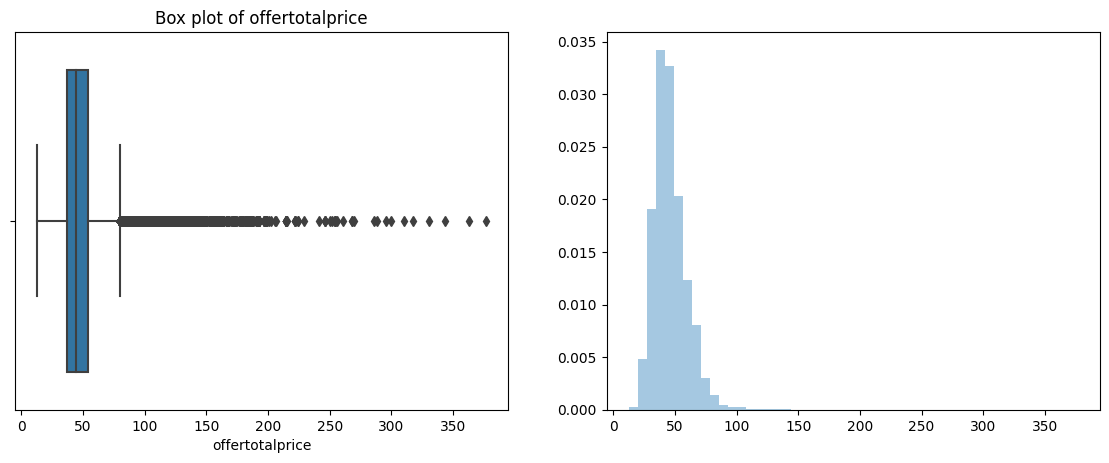

In [44]:
# inspect numerical feats

bsp.num_plotchart(df_raw2, float_cols)

### Item Age

In [ ]:
bsp.grouped_num_kde(df_raw2, 'AppAge', 'cancelflag')

In [ ]:
df_raw2.columns

In [ ]:
num_plot_no_pred(df_raw2, ['AppAge'], 1, 1, 'cancelflag', 'offertotalprice', nbins=10, target_lim = None)

### Purchase Price

In [45]:
df = df_raw2.copy()

# cap price
df = df[df['PurchasePrice'] <= 1500]

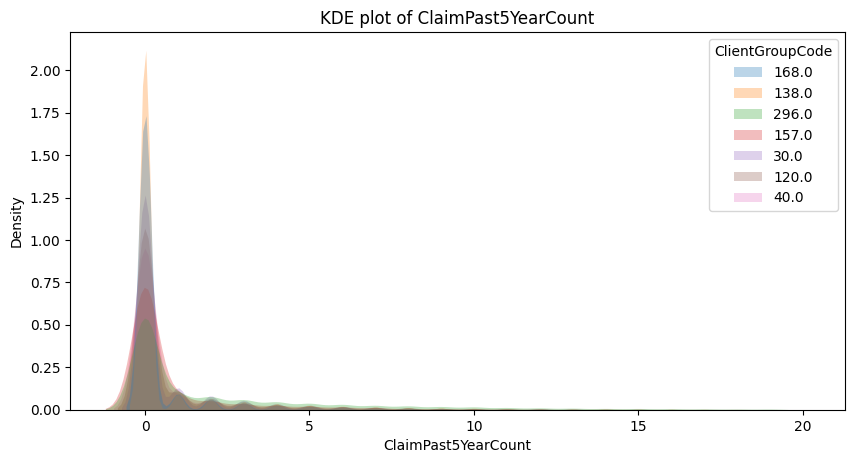

In [46]:
# ClaimPast5YearCount capped below 20
bsp.grouped_num_kde(df[df['ClaimPast5YearCount']<20], 'ClaimPast5YearCount', 'ClientGroupCode')

In [47]:
# cap claims

df = df[df['ClaimPast5YearCount']<=10]

## Outlier Treatment
<a id='out'></a>

In [48]:
# remove outliers 

for i in ['PurchasePrice','ClaimAmount5YearTotal', 'PlansCancelledPast5YearCount', 'PlansActivePast1yrCount', 'PlansAcceptedPast5YearCount', 'PlansAcceptedPast1YearCount', 'AppAge', 'PlanLiveCount'
]:    
    df_filt = df[~df[i].isin(dif.findoutliers(df[i]))]

df_filt.shape

(641180, 71)

In [49]:
df_filt[['PeriodOfCover', 'PaymentType']].head()

,PeriodOfCover,PaymentType
0,12.0,DD
1,12.0,DD
2,12.0,DD
3,12.0,DD
4,12.0,DD


In [50]:
conn_s3.write(df_filt, 'TelReg_Canx_dedup.csv')

File saved as :TelReg_Canx_dedup.csv


In [ ]:
df_filt[['Postcode_Sector','personaddresspostcode']].head()